# What factors influences APR and loan completion probability?
## by Abdalla Gabara

## Investigation Overview

> The first aim of this study is to determine which factors charcterizes completed loans as opposed to defaulted or charged off loans. <br>
> The second aim is to determine which factors correlates with APR for each loan.

## Dataset Overview

> The dataset in hand contains the relevant information of 113,937 loans isseued between 2005 and 2014. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
def relative_freq_loanstat(col, sort=True):
    
    loan_status=df.LoanStatus.unique()
    loan_status=loan_status[loan_status != 'Current'] # We are not currrently interesrted in current loans
    
    unique_values=df[col].unique()
    unique_values=unique_values[~np.isnan(unique_values)]
    if sort:
        unique_values=np.sort(unique_values)
    status_df = pd.DataFrame(index=unique_values, columns=loan_status)
    
    for value in unique_values:
        for stat in loan_status:
            total_count=df.loc[(df[col] == value) & (df.LoanStatus != 'Current')].shape[0]
            if total_count>0:
                rel_freq= df.loc[(df[col] == value)&(df.LoanStatus == stat)].shape[0]/ total_count
            else:
                rel_freq=0
            status_df.loc[value, stat] = rel_freq
    return status_df

In [4]:
df.loc[df.LoanStatus.str.contains('Past Due'),'LoanStatus']='Incomplete'
df.loc[df.LoanStatus.str.contains('FinalPaymentInProgress'),'LoanStatus']='Completed'
df.loc[df.LoanStatus.str.contains('Defaulted'),'LoanStatus']='Incomplete'
df.loc[df.LoanStatus.str.contains('Chargedoff'),'LoanStatus']='Incomplete'
df.loc[df.LoanStatus.str.contains('Cancelled'),'LoanStatus']='Incomplete'


In [5]:
income_dic = {'IncomeRange': [ 'Not employed','$0','$1-24,999','$25,000-49,999',  '$50,000-74,999', 
                            '$75,000-99,999', '$100,000+' , 'Not displayed'],
                   }

ordered_income = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = income_dic['IncomeRange'])
df['IncomeRange'] = df['IncomeRange'].astype(ordered_income)

## APR Disribution

There is an interesting spike at around 36% APR value. Other than that APRs seem to be distributed exenly except at the tails.

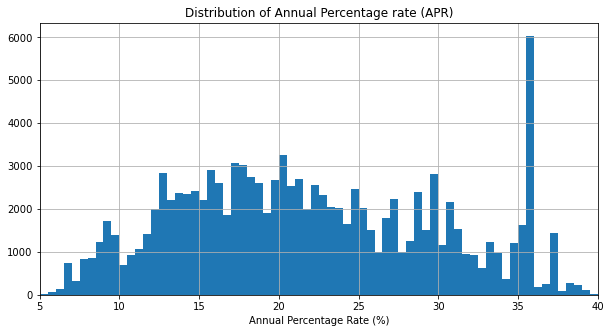

In [6]:
binsize = 0.005
bins = np.arange(0, df['BorrowerAPR'].max()*100+binsize*100, binsize*100)
plt.figure(figsize=[10, 5])
(df['BorrowerAPR']*100).hist(bins=bins);
plt.title('Distribution of Annual Percentage rate (APR)')
plt.xlim([5, 40])
plt.xlabel('Annual Percentage Rate (%)')
plt.ylabel('')
plt.show()

## Loan Status Distribution


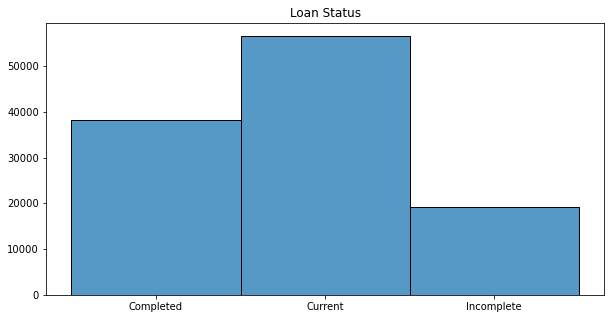

In [7]:
plt.figure(figsize=[10, 5])
sns.histplot(df['LoanStatus']);
plt.xlabel('');
plt.ylabel('');
plt.title('Loan Status');

## How good is credit score in predicting loan completion?

Credit Score of the borrower seems to be a good indicator of the probability of a completed loan, as the following plot shows such high correlations clearly

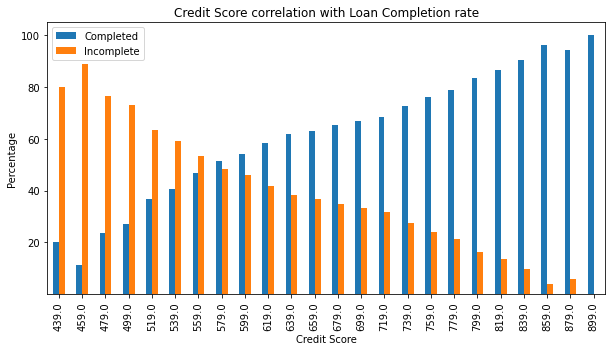

In [8]:
status_score=relative_freq_loanstat('CreditScoreRangeUpper');
status_score[status_score.index>400].plot(kind='bar', figsize=(10,5));
plt.xlabel('Credit Score')
plt.ylabel('Percentage')
plt.yticks([0.2,0.4,0.6, 0.8, 1], [20,40,60,80,100])
plt.title('Credit Score correlation with Loan Completion rate');

## Does the length of the loan has anything to do with loan completion?

The longer the loan the less likely it is to be completed. as the following histogram shows

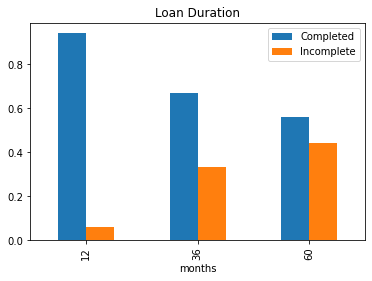

In [15]:
status_terms=relative_freq_loanstat('Term')
status_terms.plot(kind='bar');
plt.title('Loan Duration');
plt.xlabel('months');

## Does the Income of the borrower has anything to do with loan completion?

The lower the borrower's income the less likely his loan is to be completed

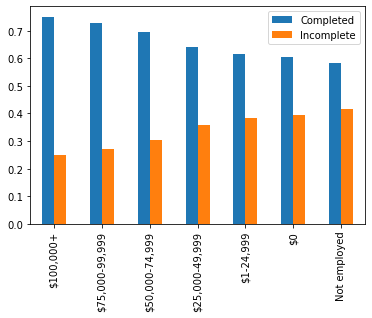

In [10]:
incomes=['$100,000+', '$75,000-99,999',  '$50,000-74,999',
      '$25,000-49,999','$1-24,999', '$0', 'Not employed', 'Not displayed']
status_income=pd.DataFrame(index=incomes, columns=df.LoanStatus.unique()) #incomes were defined in the univariate section 
for inc in incomes:
    for stat in df.LoanStatus.unique():
        rel_freq= df.loc[(df.IncomeRange == inc)&(df.LoanStatus == stat)].shape[0]/ df.loc[(df.IncomeRange == inc) & (df.LoanStatus != 'Current')].shape[0]
        status_income.loc[inc, stat] = rel_freq
ax=status_income[status_income.index != 'Not displayed'].drop('Current',axis=1).plot(kind='bar');
ax.legend(loc='best');

## Is the loan amount a good predictor of loan completion?

While one might expect that larger loans are less likely to be completed, the data shows no significance difference as both incomplete and complete loans are similarily distributed across the loan amount variable

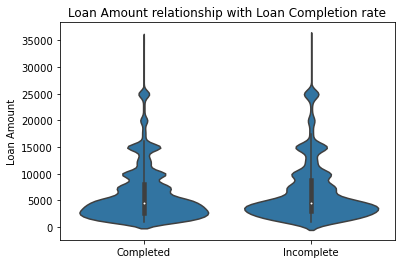

In [11]:
sns.violinplot(data=df.loc[(df.LoanStatus!='Current')], x='LoanStatus', y='LoanOriginalAmount', color=sns.color_palette()[0])
plt.xlabel('')
plt.ylabel('Loan Amount')
plt.title('Loan Amount relationship with Loan Completion rate');

## Credit Score vs APR

the higher your credit score the lower your APR is likely to be as the following regression plot shows

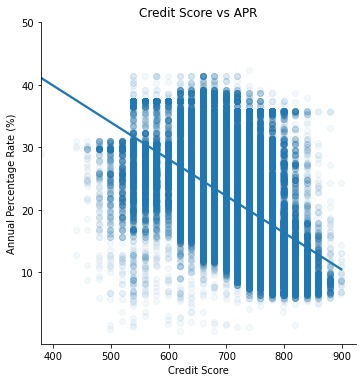

In [12]:
sns.lmplot(data=df[df['CreditScoreRangeUpper']>200],
           x='CreditScoreRangeUpper', y='BorrowerAPR', x_jitter=0.1, scatter_kws={'alpha':1/20});
plt.xlabel('Credit Score');
plt.ylabel('Annual Percentage Rate (%)');

plt.yticks([0.1,0.2,0.3, 0.4, 0.5], [10,20,30,40,50]);
plt.title('Credit Score vs APR');

## Loan Amount vs APR

the higher the amount you are borrowing the more likely your APR is to lower as the following regression plot shows weak negative correlation between the amount and APR

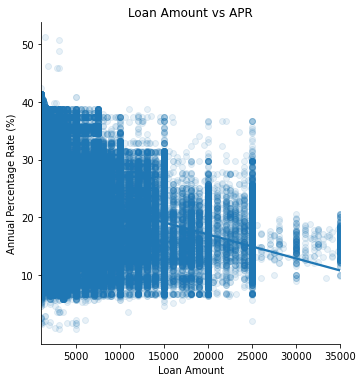

In [13]:
sns.lmplot(data=df[df['LoanOriginalAmount']>200],
           x='LoanOriginalAmount', y='BorrowerAPR', x_jitter=0.1, scatter_kws={'alpha':1/10});
plt.xlabel('Loan Amount');
plt.ylabel('Annual Percentage Rate (%)');

plt.yticks([0.1,0.2,0.3, 0.4, 0.5], [10,20,30,40,50]);
plt.title('Loan Amount vs APR');

## Recommendations vs APR

While having below 3 recommendations does not seem to make much difference, having more seems to increase the likelihood of getting lower APRs.


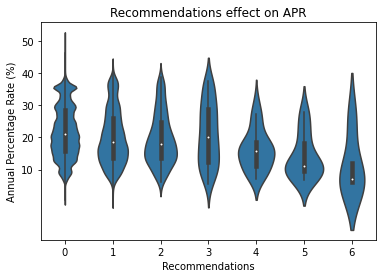

In [14]:
sns.violinplot(data=df[df['Recommendations']<7], x='Recommendations', y='BorrowerAPR', color=sns.color_palette()[0]);
plt.xlabel('Recommendations');
plt.ylabel('Annual Percentage Rate (%)');

plt.yticks([0.1,0.2,0.3, 0.4, 0.5], [10,20,30,40,50]);
plt.title('Recommendations effect on APR');

# Conclusions

Loan Completion is correlated with:
- Credit Score of the borrower (direct proportion)
- Duration of the loan (inverse proportion)
- Income of the borrower (direct proportion)
<br>


Annual Percentage Return (APR) is correlated with:
- Credit Score (Direct Proportion)
- Loan Amount (Inverse Proportion)
- Recommendations (Inverse Proportion)